## Connect to SageMaker

In [20]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer

import numpy as np
import math
import re
import pandas as pd

# Define IAM role
session = sagemaker.Session()
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
my_region = boto3.session.Session().region_name # set the region of the instance

# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", my_region, "latest")

print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + xgboost_container + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-east-1 region. You will use the 811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


## Import Data from S3

In [5]:
# connect to s3
bucket_name = 'sagemaker-studio-ez4i81odxsj' 
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
      s3.create_bucket(Bucket=bucket_name)
    else: 
      s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ', e)

S3 bucket created successfully


In [11]:
# import tweet data from s3
data_key = 'credit_risk_dataset.csv' 
data_location = 's3://{}/{}'.format(bucket_name, data_key) 

df = pd.read_csv(data_location) 

In [12]:
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [13]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [14]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

## Simple EDA & Data Cleaning

/tmp/ipykernel_7430/1276257817.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()
/tmp/ipykernel_7430/1276257817.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(250, 15, as_cmap=True, center = "dark"),


<AxesSubplot: >

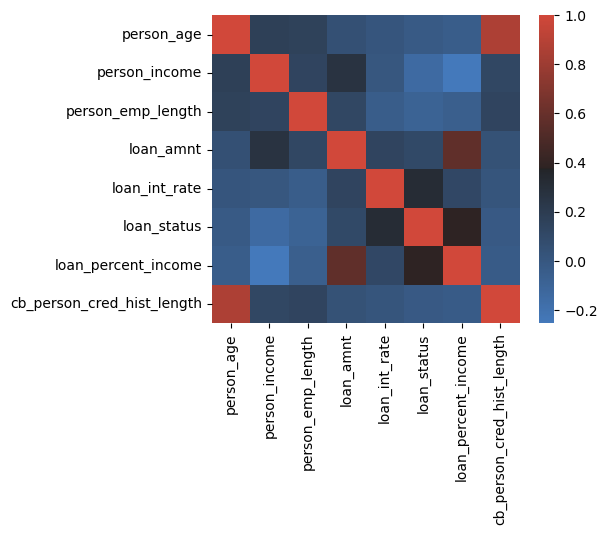

In [94]:
import seaborn as sns

f, ax = plt.subplots(figsize=(5, 4))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(250, 15, as_cmap=True, center = "dark"),
            square=True, ax=ax)

In [95]:
df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [96]:
df['person_emp_length'].fillna(df['person_emp_length'].mode()[0], inplace=True)
df['loan_int_rate'].fillna(df['loan_int_rate'].median(), inplace=True)

In [34]:
df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [97]:
cat_cols = [col for col in df.columns if df[col].dtypes == 'O']

for col in cat_cols:
    print(df[col].value_counts(), "\n\n")

RENT        16446
MORTGAGE    13444
OWN          2584
OTHER         107
Name: person_home_ownership, dtype: int64 


EDUCATION            6453
MEDICAL              6071
VENTURE              5719
PERSONAL             5521
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: loan_intent, dtype: int64 


A    10777
B    10451
C     6458
D     3626
E      964
F      241
G       64
Name: loan_grade, dtype: int64 


N    26836
Y     5745
Name: cb_person_default_on_file, dtype: int64 




In [98]:
# drop outliers
cleaned_df = df[df['person_age']<=100]
cleaned_df = cleaned_df[cleaned_df['person_emp_length']<=60]
cleaned_df = cleaned_df[cleaned_df['person_income']<=4e6]
cleaned_num_cols = pd.DataFrame(cleaned_df[cleaned_df.select_dtypes(include=['float', 'int']).columns])

In [99]:
# get the categorical variables 
cat_cols = pd.DataFrame(cleaned_df[cleaned_df.select_dtypes(include=['object']).columns])
cat_cols.columns

encoded_cat_cols = pd.get_dummies(cat_cols)
encoded_cat_cols
cleaned_df = pd.concat([cleaned_num_cols, encoded_cat_cols], axis=1)
cleaned_df.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
1,21,9600,5.0,1000,11.14,0,0.10,2,0,0,...,0,0,1,0,0,0,0,0,1,0
2,25,9600,1.0,5500,12.87,1,0.57,3,1,0,...,0,0,0,1,0,0,0,0,1,0
3,23,65500,4.0,35000,15.23,1,0.53,2,0,0,...,0,0,0,1,0,0,0,0,1,0
4,24,54400,8.0,35000,14.27,1,0.55,4,0,0,...,0,0,0,1,0,0,0,0,0,1
5,21,9900,2.0,2500,7.14,1,0.25,2,0,0,...,1,1,0,0,0,0,0,0,1,0


In [65]:
#Splitting Dataset
from sklearn.model_selection import train_test_split
x = cleaned_df.drop("loan_status", axis=1)
y = cleaned_df.loan_status

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.25)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25)

In [66]:
valset = pd.concat([Y_val, X_val], axis=1)
trainset = pd.concat([Y_train, X_train], axis=1)

In [67]:
# This is our local data directory. We need to make sure that it exists.
data_dir = '../data/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [68]:
valset.to_csv(os.path.join(data_dir, 'validation.csv'), header = False, index = False)
trainset.to_csv(os.path.join(data_dir, 'train.csv'), header = False, index = False)

In [69]:
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [100]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(session.boto_region_name, 'xgboost')

xgb = sagemaker.estimator.Estimator(container, 
                                    role,      
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge', 
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),                                        
                                    sagemaker_session=session) 

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [72]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data=val_location, content_type='csv')

xgb.fit({'train': s3_input_train, 'validation':  s3_input_validation})

INFO:sagemaker:Creating training-job with name: xgboost-2023-04-30-21-10-20-607


2023-04-30 21:10:21 Starting - Starting the training job...
2023-04-30 21:10:57 Starting - Preparing the instances for training.........
2023-04-30 21:12:19 Downloading - Downloading input data...
2023-04-30 21:12:49 Training - Downloading the training image......
2023-04-30 21:13:55 Uploading - Uploading generated training modelArguments: train
[2023-04-30:21:13:46:INFO] Running standalone xgboost training.
[2023-04-30:21:13:46:INFO] File size need to be processed in the node: 1.48mb. Available memory size in the node: 8593.16mb
[2023-04-30:21:13:46:INFO] Determined delimiter of CSV input is ','
[21:13:46] S3DistributionType set as FullyReplicated
[21:13:46] 14622x26 matrix with 380172 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2023-04-30:21:13:46:INFO] Determined delimiter of CSV input is ','
[21:13:46] S3DistributionType set as FullyReplicated
[21:13:46] 7202x26 matrix with 187252 entries loaded from /opt/ml/input/data/validation?format=csv&l

In [73]:
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2023-04-30-21-15-15-958
INFO:sagemaker:Creating endpoint-config with name xgboost-2023-04-30-21-15-15-958
INFO:sagemaker:Creating endpoint with name xgboost-2023-04-30-21-15-15-958


------!

In [82]:
from sagemaker.serializers import CSVSerializer

xgb_predictor.serializer = CSVSerializer()

Y_pred = xgb_predictor.predict(X_test.values).decode('utf-8')

Y_pred = np.fromstring(Y_pred, sep=',')
Y_pred

array([0.11190313, 0.08001968, 0.07615259, ..., 0.03428167, 0.07347393,
       0.9153977 ])